# Data Cleaning: Coreset vs Random

## Purpose
The purpose of this example is to demonstrate how the DataHeroes' dataheroes library can be used to help you clean your data by easily identifying and fixing incorrectly labeled data as well as identifying other anomalies in your dataset such as data imbalance and under-represented domains. The library uses a methodology from computational geometry known as coresets to compute the importance of each data instance in your dataset, or how much this instance can affect your model. Individual instances with high importance usually indicate a labeling error or other anomaly or outlier.
In this example, we’re using the well-known CIFAR-10 dataset. We’ve extracted the features of this dataset using ResNest18. We then introduce noise to this dataset, by mislabeling some of the data instances of the train dataset. In the next step, we compare two cleaning methods, cleaning the data using coresets and cleaning the data using random sampling. Cleaning the data using coresets is simple and requires only a few lines of code. We first instantiate the CoresetTreeServiceLG class while optimized_for='cleaning' and build the Coreset service tree using the build function. Then in each cleaning iteration, we call the get_cleaning_samples function, to retrieve samples that have high importance, which usually indicates a labeling error or other anomaly, from the classes we are interested in. In each iteration we also call update_targets to update the labels of the mislabeled samples. Finally, we have a couple of plots comparing the cleaning results of both methods, using coresets and randomly. As can be seen, using coresets, we were able to identify many, many more mislabeled instances in our dataset, which make coresets a great way to clean data. The same methodology can be easily applied to your dataset too.
We’re also providing some code examples in PyTorch and Keras/TensorFlow demonstrating how to extract the features from your dataset.

In [15]:
import copy
import pathlib
import warnings
import shutil
import gdown

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning

from dataheroes import CoresetTreeServiceLG

# Ignore convergence warnings for logistic regression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Load CIFAR10 Dataset
To view how the features were extracted for the CIFAR10 dataset using ResNet18 please refer to <a href="https://github.com/Data-Heroes/dataheroes/blob/master/examples/feature_extraction_scripts/feature_extraction_cifar10_resnet18_pytorch.py">this script</a> or to <a href="https://github.com/Data-Heroes/dataheroes/blob/master/examples/feature_extraction_scripts/feature_extraction_cifar10_resnet18_tensorflow_keras.py">this</a>.

In [16]:
# public folder on Google drive with data and images
url = "https://drive.google.com/drive/folders/1UVcEEYL3mBnazAjRGWetR44P81VFQ5DA"
# create local data folder
data_path = pathlib.Path('../data/cifar10_resnet18/generated')
data_path.mkdir(parents=True, exist_ok=True)
# download files
gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))
# unpack images
shutil.unpack_archive(str(data_path / "images.tar.gz"), str(data_path))
# load data to the memory
X_train = np.load(str(data_path / "x_train.npy"))
X_test = np.load(str(data_path / "x_test.npy"))
y_train = np.load(str(data_path / "y_train.npy"))
y_test = np.load(str(data_path / "y_test.npy"))

## Initialize a logistic regression classifier
We've set max_iter to 500 to get better convergence. Reduce this number to speed up the runtime.

In [17]:
clf_params = {"class_weight": "balanced", "max_iter": 500}
clf = LogisticRegression(**clf_params)

## Define the evaluation method

In [18]:
def eval_clf(y_train_to_eval):
    clf.fit(X_train, y_train_to_eval)
    return roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr")

## Evaluate model on the clean data

In [19]:
score_clean = eval_clf(y_train)

## Select the classes to mislabel
We’re selecting 3 classes from which we’re then going to randomly select samples to be mislabeled.
The 3 selected classes are the ones in which the prediction model missed mostly, based on the confusion matrix.

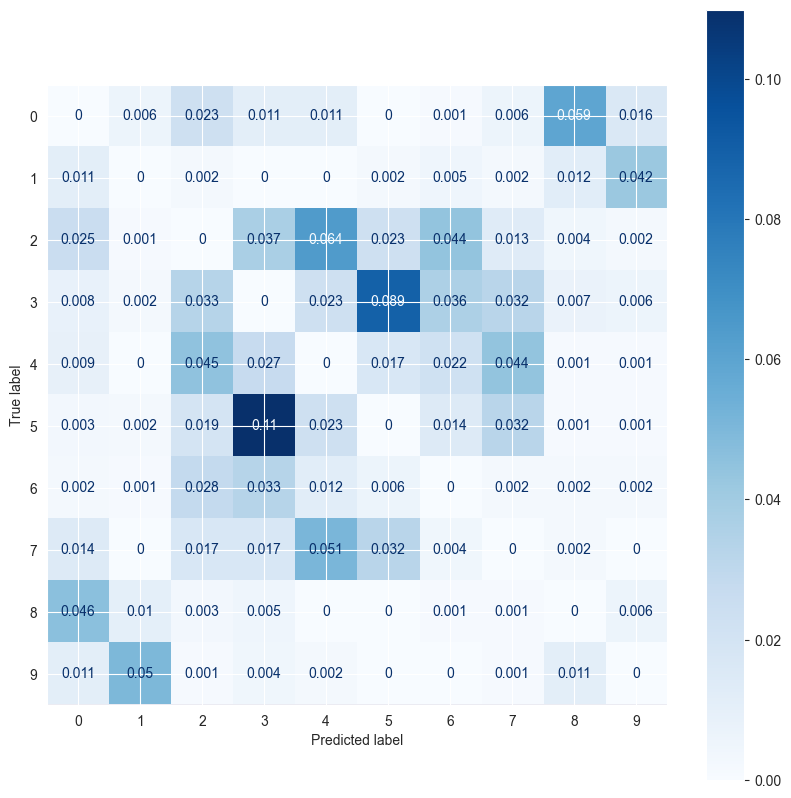

classes_transform=[(5, 3), (3, 5), (2, 4)]


In [20]:
n_weak_cls = 3
classes_transform = []
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, clf.predict(X_test), normalize="true")
np.fill_diagonal(cm, 0)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot(cmap = "Blues", ax = ax)
plt.show()
for _ in range(n_weak_cls):
     # Select the cell with the highest value.
    from_to = np.where(cm == cm.max())
     # First element in the from_to tuple is the correct label and the second element is the predicted label.
    classes_transform.append((from_to[0][0], from_to[1][0]))
    # Set to zero so that it won't be chosen on the next iteration.
    cm[from_to[0], from_to[1]] = 0
print(f'{classes_transform=}')

## Add some noise to y_train
Change some of the labels in y_train (mislabel).

In [21]:
noise_amount = 600
noise_amount_per_class = noise_amount // len(classes_transform)
print(f'{noise_amount_per_class=}')
y_train_noise_orig = copy.deepcopy(y_train)
chosen = np.array([], dtype=int)
for from_class, to_class in classes_transform:    
    y_from_ind = np.where(y_train_noise_orig == from_class)[0]
    y_from_ind = np.setdiff1d(y_from_ind, chosen)
    np.random.shuffle(y_from_ind)
    y_train_noise_orig[y_from_ind[:noise_amount_per_class]] = to_class
    chosen = np.concatenate([chosen, y_from_ind[:noise_amount_per_class]])

mislabeled_classes = [c[1] for c in classes_transform]

noise_amount_per_class=200


## Evaluate before cleaning

In [22]:
score_before_cleaning = eval_clf(y_train_noise_orig)

## Fix labels simulation method

In [23]:
def fix_labels(y_train_to_fix, idxs):
    """In reality this is a manual procedure, but in this simulation, we know the correct and original label"""
    y_train_to_fix[idxs] = y_train[idxs]
    return y_train_to_fix

## Set cleaning params

In [24]:
n_iterations = 10
n_samples_per_iter = 100
# Define for each class how many samples to fix in each iteration.
# The amount considers the times a class appears in mislabeled classes.
classes, counts = np.unique(mislabeled_classes,return_counts=True)
counts = counts * n_samples_per_iter//len(mislabeled_classes)
samples_per_class = dict(zip(classes, counts))
print(f'{samples_per_class=}')

samples_per_class={3: 33, 4: 33, 5: 33}


## Clean data using the coreset service

In [25]:
coreset_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_noise_orig)
viewed_indices = np.array([]).astype(int)
dataset_indices = np.arange(0, len(X_train), dtype=int)

service = CoresetTreeServiceLG(optimized_for='cleaning', n_instances=len(y_train_noise))
# Ignore convergence warnings for logistic regression
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
service.build(X_train, y_train_noise, indices=dataset_indices)

for i in range(n_iterations):
    # Returns indices of most important samples order by importance.
    result = service.get_cleaning_samples(
        class_size=samples_per_class,
    )
    
    important_samples = result['idx']
    y_train_noise = fix_labels(y_train_noise, important_samples)
    service.update_targets(
        indices=important_samples,
        y=y_train_noise[important_samples],
    )

    viewed_indices = np.concatenate([viewed_indices, important_samples])
    score = eval_clf(y_train_noise)
    fixed = np.sum(y_train_noise != y_train_noise_orig)
    coreset_result['score'].append(score)
    coreset_result['fixed'].append(fixed)
    coreset_result['viewed'].append(len(viewed_indices))

## Clean data using random sampling

In [26]:
random_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_noise_orig)
viewed_indices = np.array([]).astype(int)
for i in range(n_iterations):
    for cls, amount in samples_per_class.items():
        rand_idxs = np.where(y_train_noise==cls)[0]
        rand_idxs = np.setdiff1d(rand_idxs, viewed_indices)
        np.random.shuffle(rand_idxs)
        rand_idxs = rand_idxs[:amount]
        y_train_noise = fix_labels(y_train_noise, rand_idxs)
        viewed_indices = np.concatenate([viewed_indices, rand_idxs])
    score = eval_clf(y_train_noise)
    fixed = np.sum(y_train_noise != y_train_noise_orig)
    random_result['score'].append(score)
    random_result['fixed'].append(fixed)
    random_result['viewed'].append(len(viewed_indices))

## Plot AUC chart

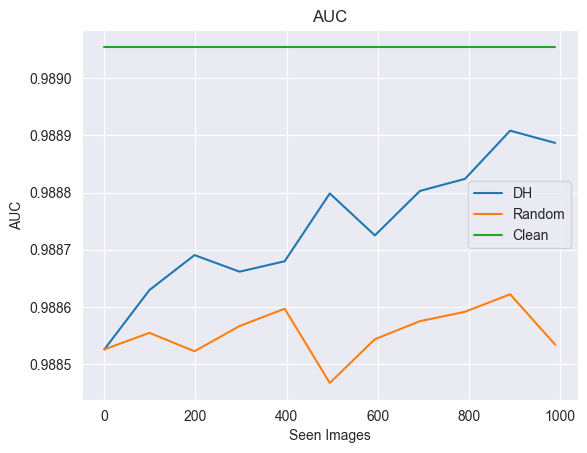

In [27]:
plt.plot(coreset_result["viewed"],coreset_result["score"], label="DH")
plt.plot(random_result["viewed"], random_result["score"],label="Random")
plt.plot(coreset_result["viewed"], np.ones(len(coreset_result["viewed"])) * score_clean, label="Clean")
plt.ylabel("AUC")
plt.xlabel("Seen Images")
plt.title("AUC")
plt.legend()
plt.show()

## Plot Fixed chart

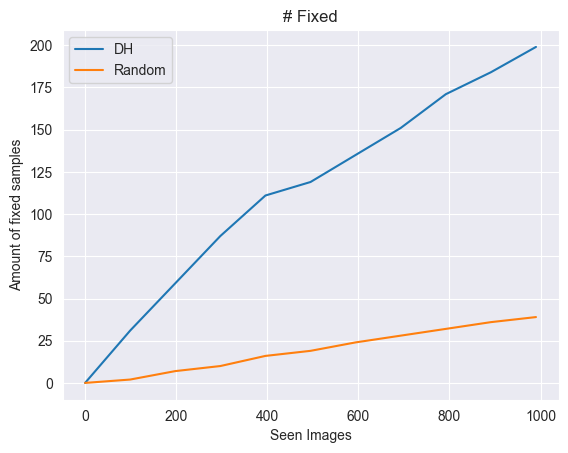

In [28]:
plt.plot(coreset_result["viewed"], coreset_result["fixed"], label="DH")
plt.plot(random_result["viewed"], random_result["fixed"], label="Random")
plt.ylabel("Amount of fixed samples")
plt.xlabel("Seen Images")
plt.title("# Fixed")
plt.legend()
plt.show()